In [1]:
# Import libraries
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.sparse import issparse
from datetime import datetime
from tqdm import tqdm
from sklearn import metrics
from scipy import stats
import warnings
import sys


# Set plotting settings
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, frameon=False)

BASE_DIR = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Linda_RNA/"

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
samples = {
    "Emx1_Ctrl": "cellranger_counts_R26_Emx1_Ctrl_adult_0",
    "Emx1_Mut": "cellranger_counts_R26_Emx1_Mut_adult_1",
    "Nestin_Ctrl": "cellranger_counts_R26_Nestin_Ctrl_adult_2",
    "Nestin_Mut": "cellranger_counts_R26_Nestin_Mut_adult_3"
    }

In [4]:
# This cell will be parameterized by the script
SAMPLE_NAME = "Emx1_Ctrl"  # This will be replaced with the actual sample name
# SAMPLE_NAME = "Emx1_Ctrl"
print(f"Processing sample: {SAMPLE_NAME}")

# %% [markdown]
# # 1. Setup and Data Loading

Processing sample: Emx1_Ctrl


In [5]:
SAMPLE = samples[SAMPLE_NAME]

WORKING_DIR = os.path.join(BASE_DIR, "post_analysis", "individual_data_analysis_opt_clusters", SAMPLE)
os.makedirs(WORKING_DIR, exist_ok=True)

CELL_DATA_DIR = "cellranger_final_count_data"
matrix_dir = os.path.join(BASE_DIR, CELL_DATA_DIR, SAMPLE, "outs", "filtered_feature_bc_matrix")

os.chdir(WORKING_DIR)
OUTPUT_DIR=WORKING_DIR

sys.path.append(os.path.join(BASE_DIR, "post_analysis", "individual_data_analysis_opt_clusters"))
from functions import *

# Load the data from the filtered matrix
try:
    adata = sc.read_10x_mtx(
        matrix_dir,
        var_names='gene_symbols',
        cache=True
    )
    print(f"Shape of loaded data: {adata.shape}")  # cells × genes
except ValueError as e:
    print(f"Error loading data: {e}")
    # Try loading with different parameters to handle the mismatch
    adata = sc.read_10x_mtx(
        matrix_dir,
        var_names='gene_symbols',
        cache=False
    )
    print(f"Shape of loaded data after retry: {adata.shape}")  # cells × genes

# %% [markdown]
# # 2. Basic Pre-processing

... reading from cache file cache/beegfs-scratch-ric.broccoli-kubacki.michal-SRF_Linda_RNA-cellranger_final_count_data-cellranger_counts_R26_Emx1_Ctrl_adult_0-outs-filtered_feature_bc_matrix-matrix.h5ad


Shape of loaded data: (5056, 33696)


filtered out 7625 genes that are detected in less than 3 cells


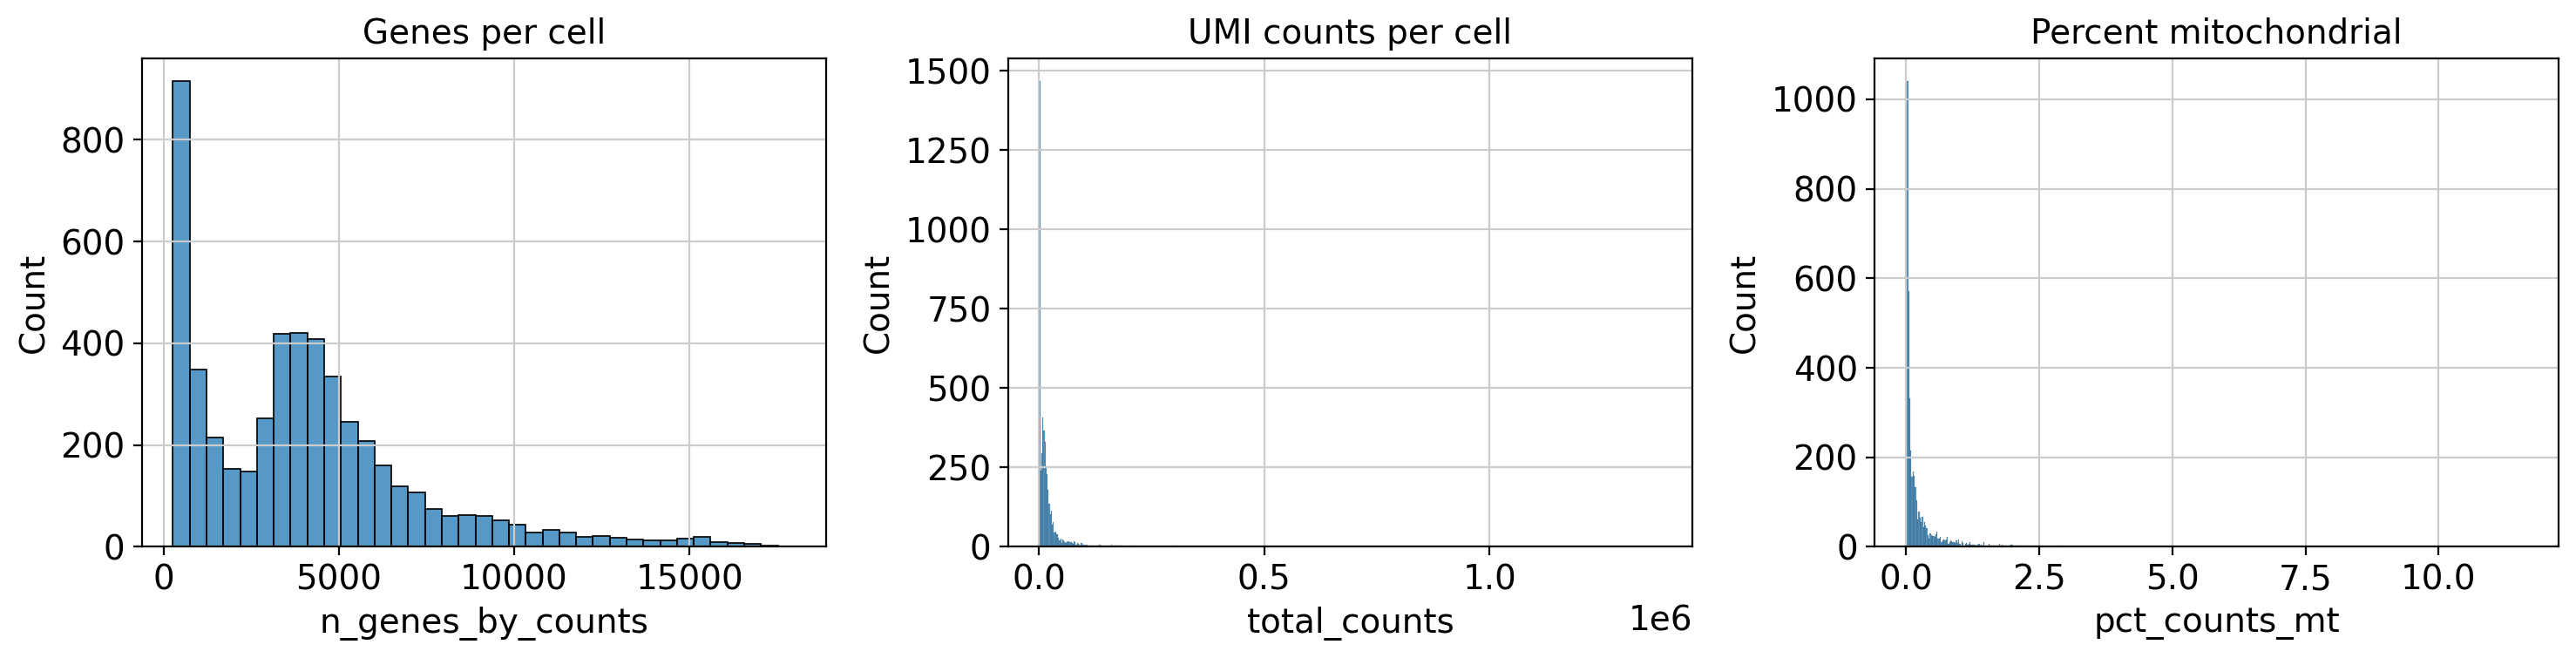

In [6]:
# Make a copy of the raw counts
adata.raw = adata.copy()

# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Calculate QC metrics
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # identify mitochondrial genes
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Plot QC metrics
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(adata.obs['n_genes_by_counts'], kde=False, ax=axs[0])
axs[0].set_title('Genes per cell')
sns.histplot(adata.obs['total_counts'], kde=False, ax=axs[1])
axs[1].set_title('UMI counts per cell')
sns.histplot(adata.obs['pct_counts_mt'], kde=False, ax=axs[2])
axs[2].set_title('Percent mitochondrial')
plt.tight_layout()

# Save the plot to the output directory
plt.savefig(os.path.join(OUTPUT_DIR, 'qc_metrics.png'))
plt.show()

# %% [markdown]
# # 3. Filtering Based on QC Metrics

In [7]:
max_genes = 15000 
min_genes = 500  
max_mt_pct = 20  

adata = adata[adata.obs['n_genes_by_counts'] < max_genes, :]
adata = adata[adata.obs['n_genes_by_counts'] > min_genes, :]
adata = adata[adata.obs['pct_counts_mt'] < max_mt_pct, :]

print(f"Number of cells after filtering: {adata.n_obs}")
print(f"Number of genes after filtering: {adata.n_vars}")

# %% [markdown]
# # 4. Normalization and Log Transformation

Number of cells after filtering: 4707
Number of genes after filtering: 26071


normalizing counts per cell


    finished (0:00:00)


extracting highly variable genes


    finished (0:00:00)


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Number of highly variable genes: 7637


<Figure size 1000x800 with 0 Axes>

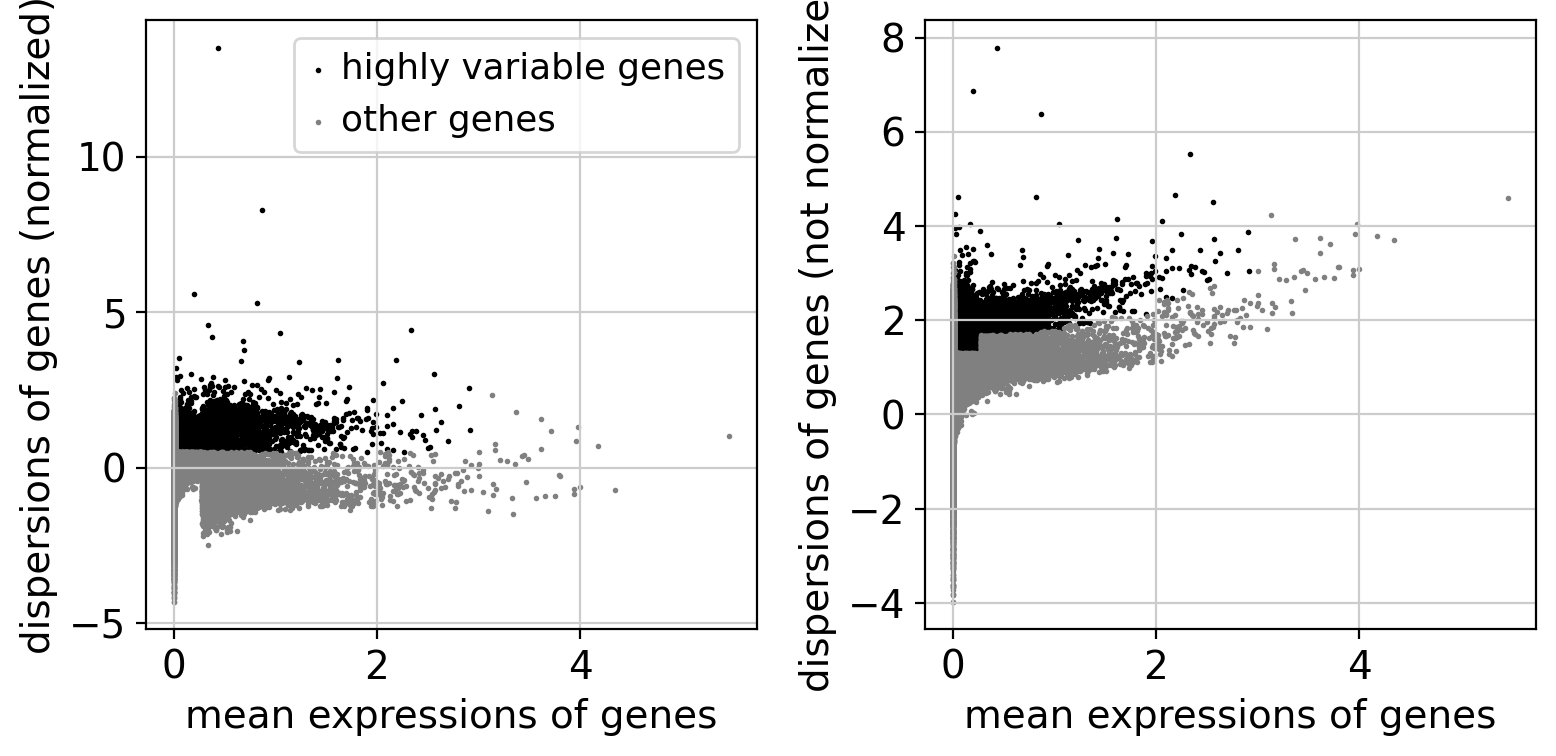

In [8]:
# Normalize to 10,000 reads per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# Log transform
sc.pp.log1p(adata)

# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
print(f"Number of highly variable genes: {sum(adata.var.highly_variable)}")

# Plot highly variable genes
plt.figure(figsize=(10, 8))
sc.pl.highly_variable_genes(adata, show=False)
plt.tight_layout()
plt.show()

In [9]:
# Save the current normalized and log-transformed data to a new layer BEFORE scaling
adata.layers['for_cell_typist'] = adata.X.copy()

In [10]:
# Quick check that the data in the layer is correctly normalized
# Reverse log1p transformation
if issparse(adata.layers['for_cell_typist']):
    counts_in_layer = adata.layers['for_cell_typist'].copy()
    counts_in_layer.data = np.expm1(counts_in_layer.data)
else:
    counts_in_layer = np.expm1(adata.layers['for_cell_typist'])

# Sum counts per cell
total_counts_layer = np.asarray(counts_in_layer.sum(axis=1)).flatten()

print("\nVerifying normalization in 'for_cell_typist' layer:")
print(f"  Mean total counts (reversed log1p): {total_counts_layer.mean():.2f}")
print(f"  Median total counts (reversed log1p): {np.median(total_counts_layer):.2f}")

# Basic QC check for the layer
if np.mean(total_counts_layer) < 9900 or np.mean(total_counts_layer) > 10100:
    warnings.warn(f"Normalization in 'for_cell_typist' layer may not be exactly 10k (Mean: {total_counts_layer.mean():.2f}). Check normalization step.")
else:
    print("  Normalization in 'for_cell_typist' layer appears correct (around 10k).")

# %% [markdown]
# # 5. Dimensionality Reduction


Verifying normalization in 'for_cell_typist' layer:
  Mean total counts (reversed log1p): 10000.00
  Median total counts (reversed log1p): 10000.00
  Normalization in 'for_cell_typist' layer appears correct (around 10k).


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


computing PCA


    with n_comps=50


    finished (0:00:18)


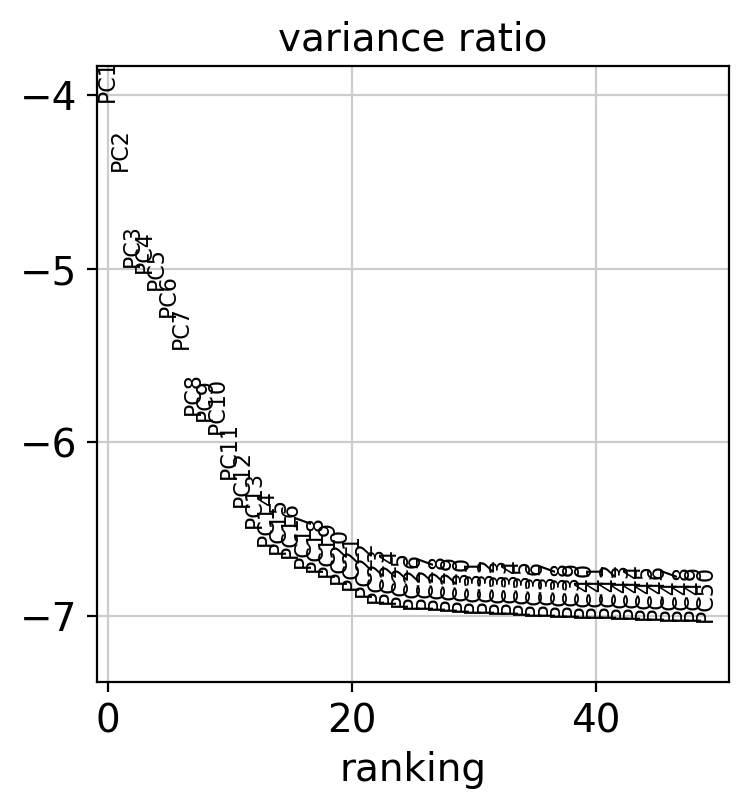

In [11]:
# Scale adata.X to unit variance and zero mean AFTER saving the normalized layer
# This step modifies adata.X but leaves adata.layers['for_cell_typist'] untouched
sc.pp.scale(adata, max_value=10)

# Run PCA
sc.tl.pca(adata, svd_solver='arpack')

# Determine number of significant PCs
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)
plt.show()

computing neighbors


    using 'X_pca' with n_pcs = 30


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


computing UMAP


    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:09)


<Figure size 1000x800 with 0 Axes>

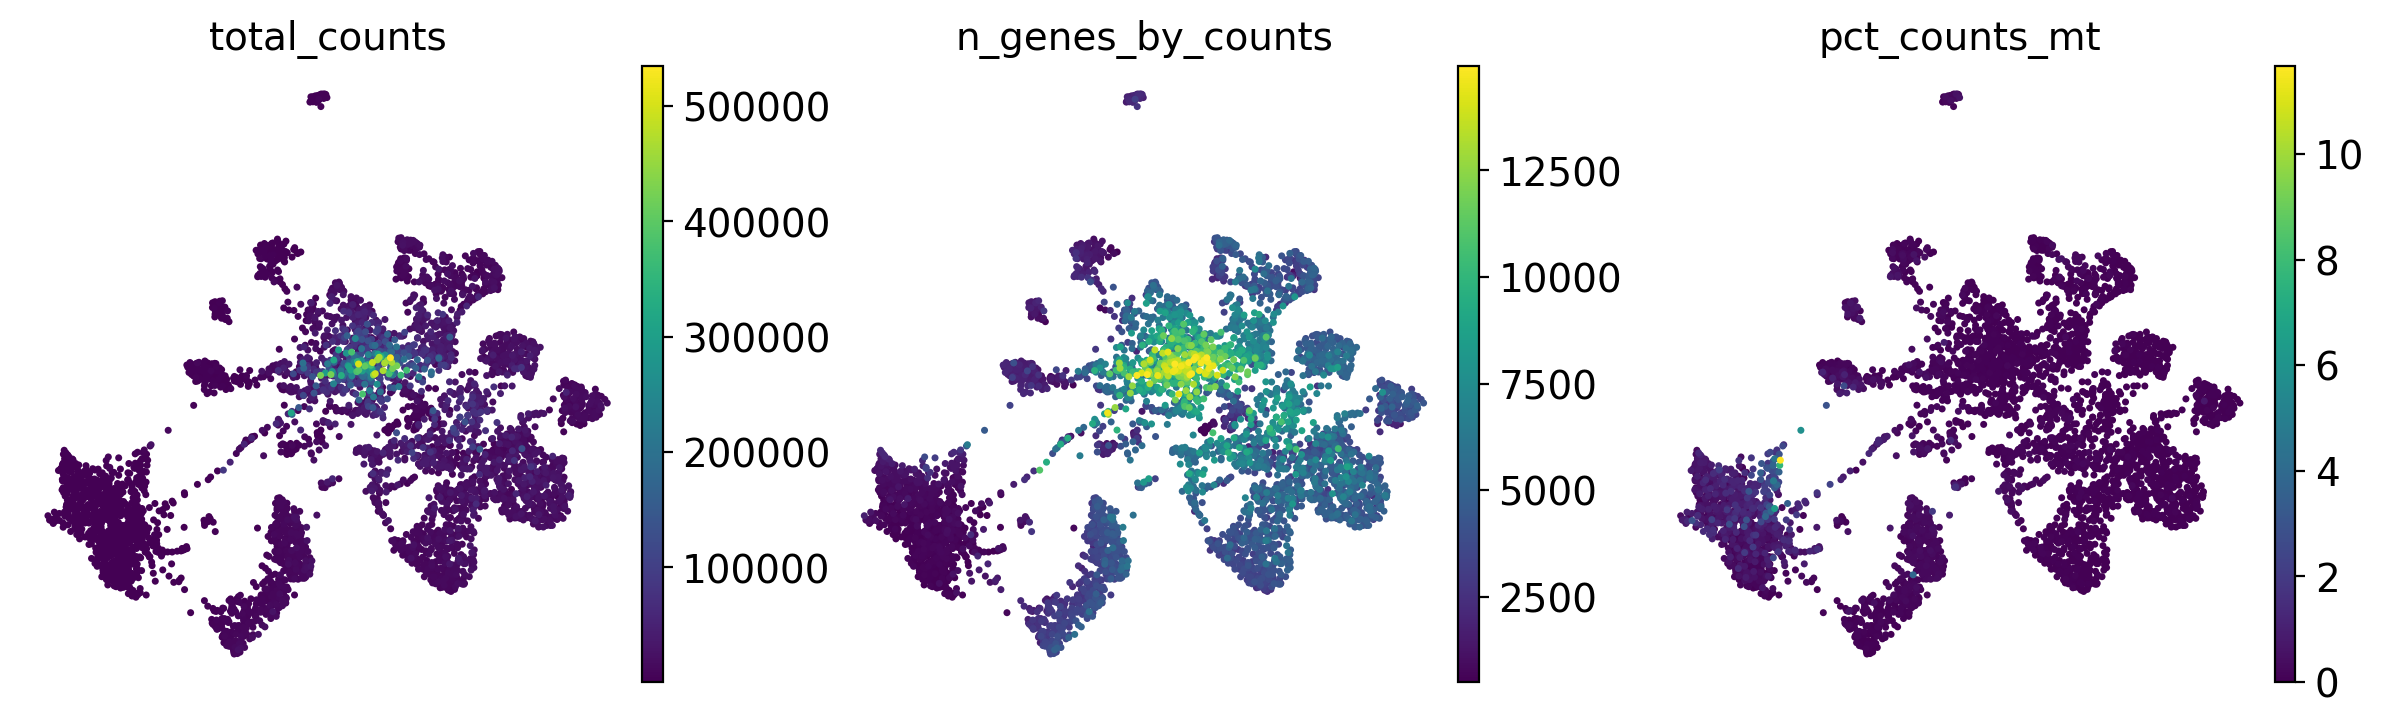

In [12]:
# Choose number of PCs for downstream analyses
n_pcs = 30  # Adjust based on the variance ratio plot

# Compute neighborhood graph
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=n_pcs)

# Run UMAP
sc.tl.umap(adata)

# Plot UMAP
plt.figure(figsize=(10, 8))
sc.pl.umap(adata, color=['total_counts', 'n_genes_by_counts', 'pct_counts_mt'], 
        use_raw=False, color_map='viridis', show=False)
plt.tight_layout()
plt.show()

# %% [markdown]
# # 6. Marker Gene Identification

In [13]:
# Try different resolutions to find optimal number of clusters
resolution_range=[0.05, 0.8]
n_resolutions=10
resolutions = np.linspace(resolution_range[0], resolution_range[1], n_resolutions)
resolutions = [round(r, 2) for r in resolutions]

In [14]:
# Check first 5 values from first cell
if issparse(adata.X):
    print("X matrix values (first cell):", adata.X[0, :5].toarray().flatten())
else:
    print("X matrix values (first cell):", adata.X[0, :5])
print("Should be log1p transformed values (~0-5 range)")

# Check raw values if raw exists
if adata.raw:
    if issparse(adata.raw.X):
        print("Raw values:", adata.raw.X[0, :5].toarray().flatten())
    else:
        print("Raw values:", adata.raw.X[0, :5])
    print("Should be original counts (integers)")


X matrix values (first cell): [-1.7288576  -0.48740408 -0.73193514 -0.02949955 -0.07023324]
Should be log1p transformed values (~0-5 range)
Raw values: [0. 0. 0. 0. 0.]
Should be original counts (integers)


In [15]:
# With custom parameters
optimal_resolution = analyze_and_select_best_clustering(
    adata,
    resolutions=resolutions,
    run_marker_analysis=True,       # Run marker gene analysis
    leiden_key='leiden',            # Base name for cluster labels
    output_dir="my_cluster_analysis"  # Output directory
)

# Annotate adata with optimal clustering (if not already present)
best_clustering = f"leiden_{optimal_resolution}"
if best_clustering not in adata.obs:
    sc.tl.leiden(adata, resolution=optimal_resolution, key_added=best_clustering)

Analyzing 10 clustering resolutions: [0.05, 0.13, 0.22, 0.3, 0.38, 0.47, 0.55, 0.63, 0.72, 0.8]

Step 1: Running Leiden clustering at different resolutions...


Computing clusterings:   0%|          | 0/10 [00:00<?, ?it/s]

running Leiden clustering


    finished: found 6 clusters and added
    'leiden_0.05', the cluster labels (adata.obs, categorical) (0:00:00)


Computing clusterings:  10%|█         | 1/10 [00:00<00:02,  4.17it/s]

running Leiden clustering


    finished: found 10 clusters and added
    'leiden_0.13', the cluster labels (adata.obs, categorical) (0:00:00)


Computing clusterings:  20%|██        | 2/10 [00:00<00:01,  5.16it/s]

running Leiden clustering


    finished: found 13 clusters and added
    'leiden_0.22', the cluster labels (adata.obs, categorical) (0:00:00)


Computing clusterings:  30%|███       | 3/10 [00:00<00:01,  5.86it/s]

running Leiden clustering


    finished: found 15 clusters and added
    'leiden_0.3', the cluster labels (adata.obs, categorical) (0:00:00)


Computing clusterings:  40%|████      | 4/10 [00:00<00:00,  6.01it/s]

running Leiden clustering


    finished: found 15 clusters and added
    'leiden_0.38', the cluster labels (adata.obs, categorical) (0:00:00)


Computing clusterings:  50%|█████     | 5/10 [00:00<00:00,  6.09it/s]

running Leiden clustering


    finished: found 16 clusters and added
    'leiden_0.47', the cluster labels (adata.obs, categorical) (0:00:00)


Computing clusterings:  60%|██████    | 6/10 [00:01<00:00,  5.33it/s]

running Leiden clustering


    finished: found 17 clusters and added
    'leiden_0.55', the cluster labels (adata.obs, categorical) (0:00:00)


Computing clusterings:  70%|███████   | 7/10 [00:01<00:00,  5.79it/s]

running Leiden clustering


    finished: found 18 clusters and added
    'leiden_0.63', the cluster labels (adata.obs, categorical) (0:00:00)


Computing clusterings:  80%|████████  | 8/10 [00:01<00:00,  5.73it/s]

running Leiden clustering


    finished: found 19 clusters and added
    'leiden_0.72', the cluster labels (adata.obs, categorical) (0:00:00)


Computing clusterings:  90%|█████████ | 9/10 [00:01<00:00,  5.32it/s]

running Leiden clustering


    finished: found 20 clusters and added
    'leiden_0.8', the cluster labels (adata.obs, categorical) (0:00:00)


Computing clusterings: 100%|██████████| 10/10 [00:01<00:00,  5.07it/s]

Computing clusterings: 100%|██████████| 10/10 [00:01<00:00,  5.39it/s]


Step 2: Identifying marker genes for each clustering resolution...


Processing resolutions:   0%|          | 0/10 [00:00<?, ?it/s]


Analyzing resolution 0.05:
ranking genes


    finished: added to `.uns['rank_genes_0.05']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:12)


  ✓ Identified differentially expressed genes


Processing resolutions:  10%|█         | 1/10 [00:13<02:04, 13.85s/it]

  ✓ Generated marker ranking plot
  ✓ Saved 10 markers per cluster to my_cluster_analysis/marker_analysis/cluster_markers_res0.05.csv

Analyzing resolution 0.13:
ranking genes


    finished: added to `.uns['rank_genes_0.13']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:17)


  ✓ Identified differentially expressed genes


Processing resolutions:  20%|██        | 2/10 [00:33<02:18, 17.31s/it]

  ✓ Generated marker ranking plot
  ✓ Saved 10 markers per cluster to my_cluster_analysis/marker_analysis/cluster_markers_res0.13.csv

Analyzing resolution 0.22:
ranking genes


    finished: added to `.uns['rank_genes_0.22']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:20)


  ✓ Identified differentially expressed genes


  ✓ Generated marker ranking plot


Processing resolutions:  30%|███       | 3/10 [00:57<02:22, 20.30s/it]

  ✓ Saved 10 markers per cluster to my_cluster_analysis/marker_analysis/cluster_markers_res0.22.csv

Analyzing resolution 0.3:
ranking genes


    finished: added to `.uns['rank_genes_0.3']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:23)


  ✓ Identified differentially expressed genes


  ✓ Generated marker ranking plot


Processing resolutions:  40%|████      | 4/10 [01:24<02:18, 23.04s/it]

  ✓ Saved 10 markers per cluster to my_cluster_analysis/marker_analysis/cluster_markers_res0.3.csv

Analyzing resolution 0.38:
ranking genes


    finished: added to `.uns['rank_genes_0.38']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:23)


  ✓ Identified differentially expressed genes


  ✓ Generated marker ranking plot


Processing resolutions:  50%|█████     | 5/10 [01:52<02:03, 24.63s/it]

  ✓ Saved 10 markers per cluster to my_cluster_analysis/marker_analysis/cluster_markers_res0.38.csv

Analyzing resolution 0.47:
ranking genes


    finished: added to `.uns['rank_genes_0.47']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:24)


  ✓ Identified differentially expressed genes


  ✓ Generated marker ranking plot


Processing resolutions:  60%|██████    | 6/10 [02:20<01:43, 25.96s/it]

  ✓ Saved 10 markers per cluster to my_cluster_analysis/marker_analysis/cluster_markers_res0.47.csv

Analyzing resolution 0.55:
ranking genes


    finished: added to `.uns['rank_genes_0.55']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:25)


  ✓ Identified differentially expressed genes


  ✓ Generated marker ranking plot


Processing resolutions:  70%|███████   | 7/10 [02:51<01:22, 27.43s/it]

  ✓ Saved 10 markers per cluster to my_cluster_analysis/marker_analysis/cluster_markers_res0.55.csv

Analyzing resolution 0.63:
ranking genes


    finished: added to `.uns['rank_genes_0.63']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:27)


  ✓ Identified differentially expressed genes


  ✓ Generated marker ranking plot


Processing resolutions:  80%|████████  | 8/10 [03:22<00:57, 28.80s/it]

  ✓ Saved 10 markers per cluster to my_cluster_analysis/marker_analysis/cluster_markers_res0.63.csv

Analyzing resolution 0.72:
ranking genes


    finished: added to `.uns['rank_genes_0.72']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:28)


  ✓ Identified differentially expressed genes


  ✓ Generated marker ranking plot


Processing resolutions:  90%|█████████ | 9/10 [03:55<00:29, 30.00s/it]

  ✓ Saved 10 markers per cluster to my_cluster_analysis/marker_analysis/cluster_markers_res0.72.csv

Analyzing resolution 0.8:
ranking genes


    finished: added to `.uns['rank_genes_0.8']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:29)


  ✓ Identified differentially expressed genes


  ✓ Generated marker ranking plot


Processing resolutions: 100%|██████████| 10/10 [04:29<00:00, 31.31s/it]

Processing resolutions: 100%|██████████| 10/10 [04:29<00:00, 26.97s/it]

  ✓ Saved 10 markers per cluster to my_cluster_analysis/marker_analysis/cluster_markers_res0.8.csv

Summary comparison saved to my_cluster_analysis/marker_analysis/resolution_comparison_summary.csv



Analysis complete. Results saved to my_cluster_analysis/marker_analysis/

Step 3: Evaluating clustering quality and selecting optimal resolution...
Evaluating clustering metrics across resolutions...


Evaluating resolutions:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating resolutions:  10%|█         | 1/10 [00:00<00:01,  4.73it/s]

Evaluating resolutions:  20%|██        | 2/10 [00:00<00:01,  4.94it/s]

Evaluating resolutions:  30%|███       | 3/10 [00:00<00:01,  4.99it/s]

Evaluating resolutions:  40%|████      | 4/10 [00:00<00:01,  5.01it/s]

Evaluating resolutions:  50%|█████     | 5/10 [00:01<00:00,  5.03it/s]

Evaluating resolutions:  60%|██████    | 6/10 [00:01<00:00,  5.06it/s]

Evaluating resolutions:  70%|███████   | 7/10 [00:01<00:00,  5.09it/s]

Evaluating resolutions:  80%|████████  | 8/10 [00:01<00:00,  5.09it/s]

Evaluating resolutions:  90%|█████████ | 9/10 [00:01<00:00,  5.08it/s]

Evaluating resolutions: 100%|██████████| 10/10 [00:01<00:00,  5.07it/s]

Evaluating resolutions: 100%|██████████| 10/10 [00:01<00:00,  5.04it/s]


Optimal clustering resolution: 0.38
Optimal number of clusters: 15
Metrics saved to my_cluster_analysis/evaluation/clustering_quality_metrics.csv


Detailed metric analysis saved to my_cluster_analysis/evaluation/metric_details

Analysis complete in 279.3 seconds!
Optimal resolution: 0.38 (15 clusters)
All clustering resolutions have been preserved in the AnnData object
Full results saved to /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Linda_RNA/post_analysis/individual_data_analysis_opt_clusters/cellranger_counts_R26_Emx1_Ctrl_adult_0/my_cluster_analysis


<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [16]:
# Load the CSV file
df = pd.read_csv(os.path.join(OUTPUT_DIR, 'my_cluster_analysis', 'evaluation', 'clustering_quality_metrics.csv'))

# Sort the dataframe by overall_score in descending order
sorted_df = df.sort_values(by='overall_score', ascending=False)

# Create an ordered list of resolutions
ordered_resolutions = sorted_df['resolution'].tolist()
scores = []
print("Resolutions ordered by overall_score (highest to lowest):")
for i, res in enumerate(ordered_resolutions, 1):
    score = sorted_df.loc[sorted_df['resolution'] == res, 'overall_score'].values[0]
    scores.append(score)
    print(f"{i}. Resolution: {res}, Overall Score: {score}")

Resolutions ordered by overall_score (highest to lowest):
1. Resolution: 0.38, Overall Score: 0.7701117868186766
2. Resolution: 0.3, Overall Score: 0.745749517359489
3. Resolution: 0.05, Overall Score: 0.7092209364573908
4. Resolution: 0.55, Overall Score: 0.6119055095258343
5. Resolution: 0.47, Overall Score: 0.6091960247622299
6. Resolution: 0.13, Overall Score: 0.5840366809677041
7. Resolution: 0.63, Overall Score: 0.5705314125347697
8. Resolution: 0.8, Overall Score: 0.5052560354880427
9. Resolution: 0.72, Overall Score: 0.5048425546109552
10. Resolution: 0.22, Overall Score: 0.3945521510211164


[0.38, 0.3, 0.05]


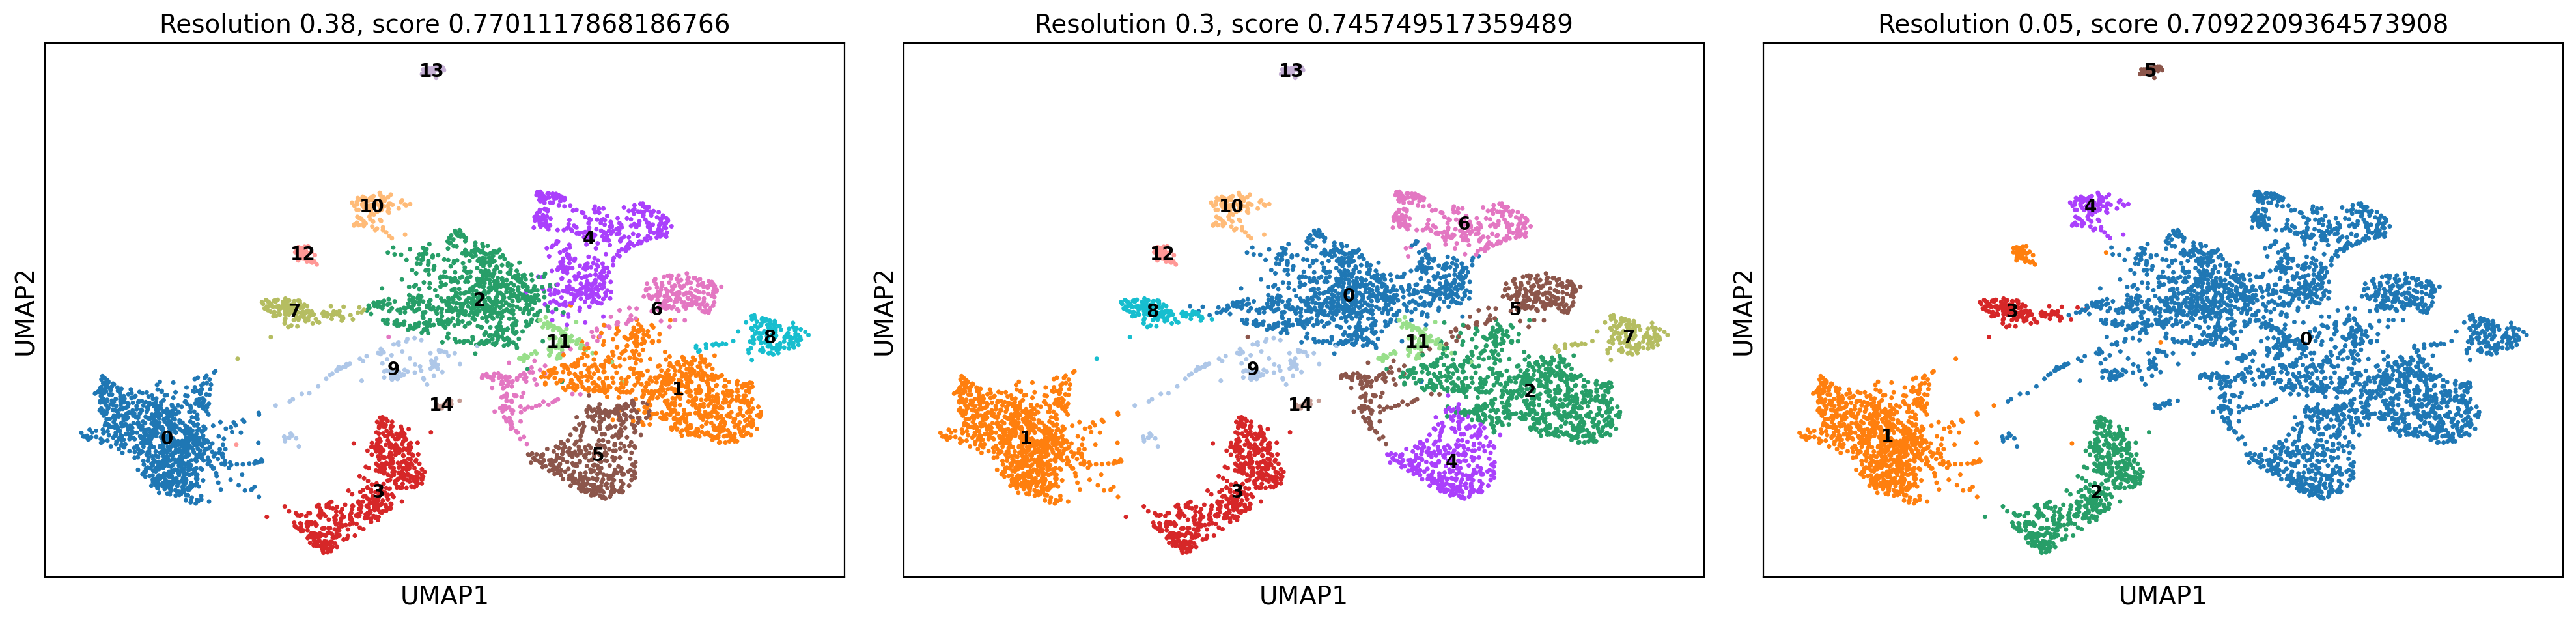

In [17]:
# Try different resolutions to find optimal number of clusters
best_resolutions = ordered_resolutions[:3]
print(best_resolutions)
# Plot clusters at different resolutions with improved layout
fig, axes = plt.subplots(1, len(best_resolutions), figsize=(20, 5))
for i, res in enumerate(best_resolutions):
    sc.pl.umap(adata, color=f'leiden_{res}', title=f'Resolution {res}, score {scores[i]}', 
               frameon=True, legend_loc='on data', legend_fontsize=10, ax=axes[i], show=False)

# Ensure proper spacing between subplots
plt.tight_layout()
plt.show()

# %% [markdown]
# # 7. Save Processed Data

In [18]:
# Define the output file path
output_adata_file = os.path.join(OUTPUT_DIR, f"{SAMPLE_NAME}_processed.h5ad")

# List all clustering assignments stored in the adata object
print("Clustering assignments stored in the AnnData object:")
leiden_columns = [col for col in adata.obs.columns if col.startswith('leiden_')]
for col in leiden_columns:
    n_clusters = len(adata.obs[col].unique())
    print(f"  - {col}: {n_clusters} clusters")

# Save the AnnData object with all clustering results
print(f"\nSaving processed AnnData object to: {output_adata_file}")
try:
    adata.write(output_adata_file)
    print("Successfully saved AnnData object with all clustering assignments.")
except Exception as e:
    print(f"Error saving AnnData object: {e}")

# %% [markdown]
# # 8. Visualize Clustering Results and Quality Metrics

Clustering assignments stored in the AnnData object:
  - leiden_0.05: 6 clusters
  - leiden_0.13: 10 clusters
  - leiden_0.22: 13 clusters
  - leiden_0.3: 15 clusters
  - leiden_0.38: 15 clusters
  - leiden_0.47: 16 clusters
  - leiden_0.55: 17 clusters
  - leiden_0.63: 18 clusters
  - leiden_0.72: 19 clusters
  - leiden_0.8: 20 clusters

Saving processed AnnData object to: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Linda_RNA/post_analysis/individual_data_analysis_opt_clusters/cellranger_counts_R26_Emx1_Ctrl_adult_0/Emx1_Ctrl_processed.h5ad


Successfully saved AnnData object with all clustering assignments.


<Figure size 1200x1000 with 0 Axes>

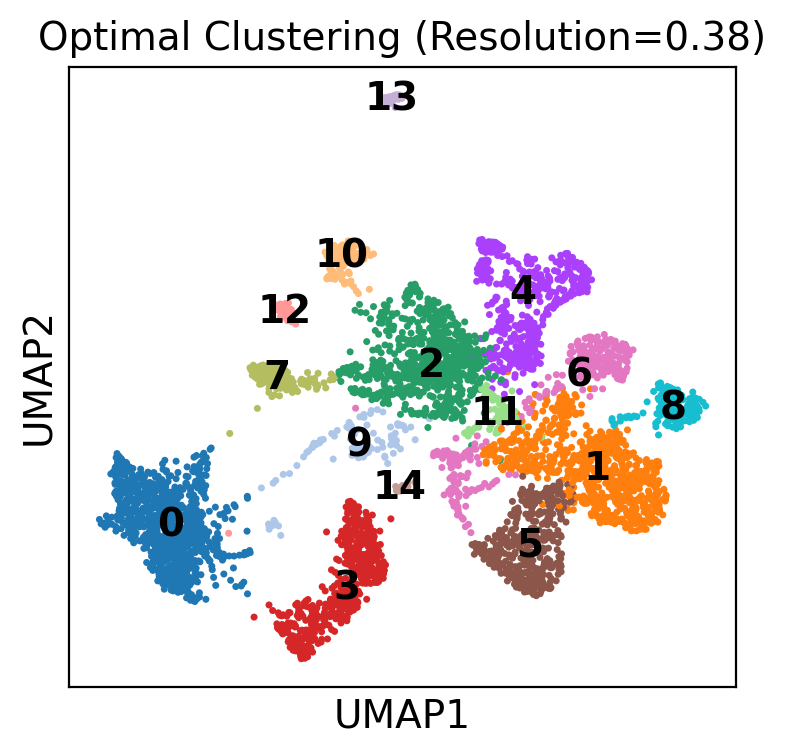

In [19]:
# Display the optimal clustering on UMAP
plt.figure(figsize=(12, 10))
sc.pl.umap(adata, color=f'leiden_{optimal_resolution}', 
           title=f'Optimal Clustering (Resolution={optimal_resolution})', 
           legend_loc='on data', frameon=True, show=False)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'optimal_clustering_umap.png'), dpi=150)
plt.show()

# %% [markdown]
# ## 8.1 Clustering Quality Metrics Analysis

In [20]:
# Load the clustering quality metrics
metrics_df = pd.read_csv(os.path.join(OUTPUT_DIR, 'my_cluster_analysis', 'evaluation', 'clustering_quality_metrics.csv'))
print("Clustering quality metrics summary:")
display(metrics_df[['resolution', 'n_clusters', 'silhouette_score', 'davies_bouldin_score', 'marker_gene_score', 'overall_score']])

Clustering quality metrics summary:


,resolution,n_clusters,silhouette_score,davies_bouldin_score,marker_gene_score,overall_score
0,0.05,6,0.108309,-1.556615,1.0,0.709221
1,0.13,10,0.047489,-1.737302,1.0,0.584037
2,0.22,13,0.048729,-1.676533,0.5,0.394552
3,0.30,15,0.077997,-1.834184,1.0,0.745750
4,0.38,15,0.083544,-1.825443,1.0,0.770112
5,0.47,16,0.081971,-1.905887,1.0,0.609196
6,0.55,17,0.080561,-1.861212,1.0,0.611906
7,0.63,18,0.075558,-1.856771,1.0,0.570531
8,0.72,19,0.067164,-1.884592,1.0,0.504843
9,0.80,20,0.063939,-1.854599,1.0,0.505256


Clustering quality metrics across resolutions:


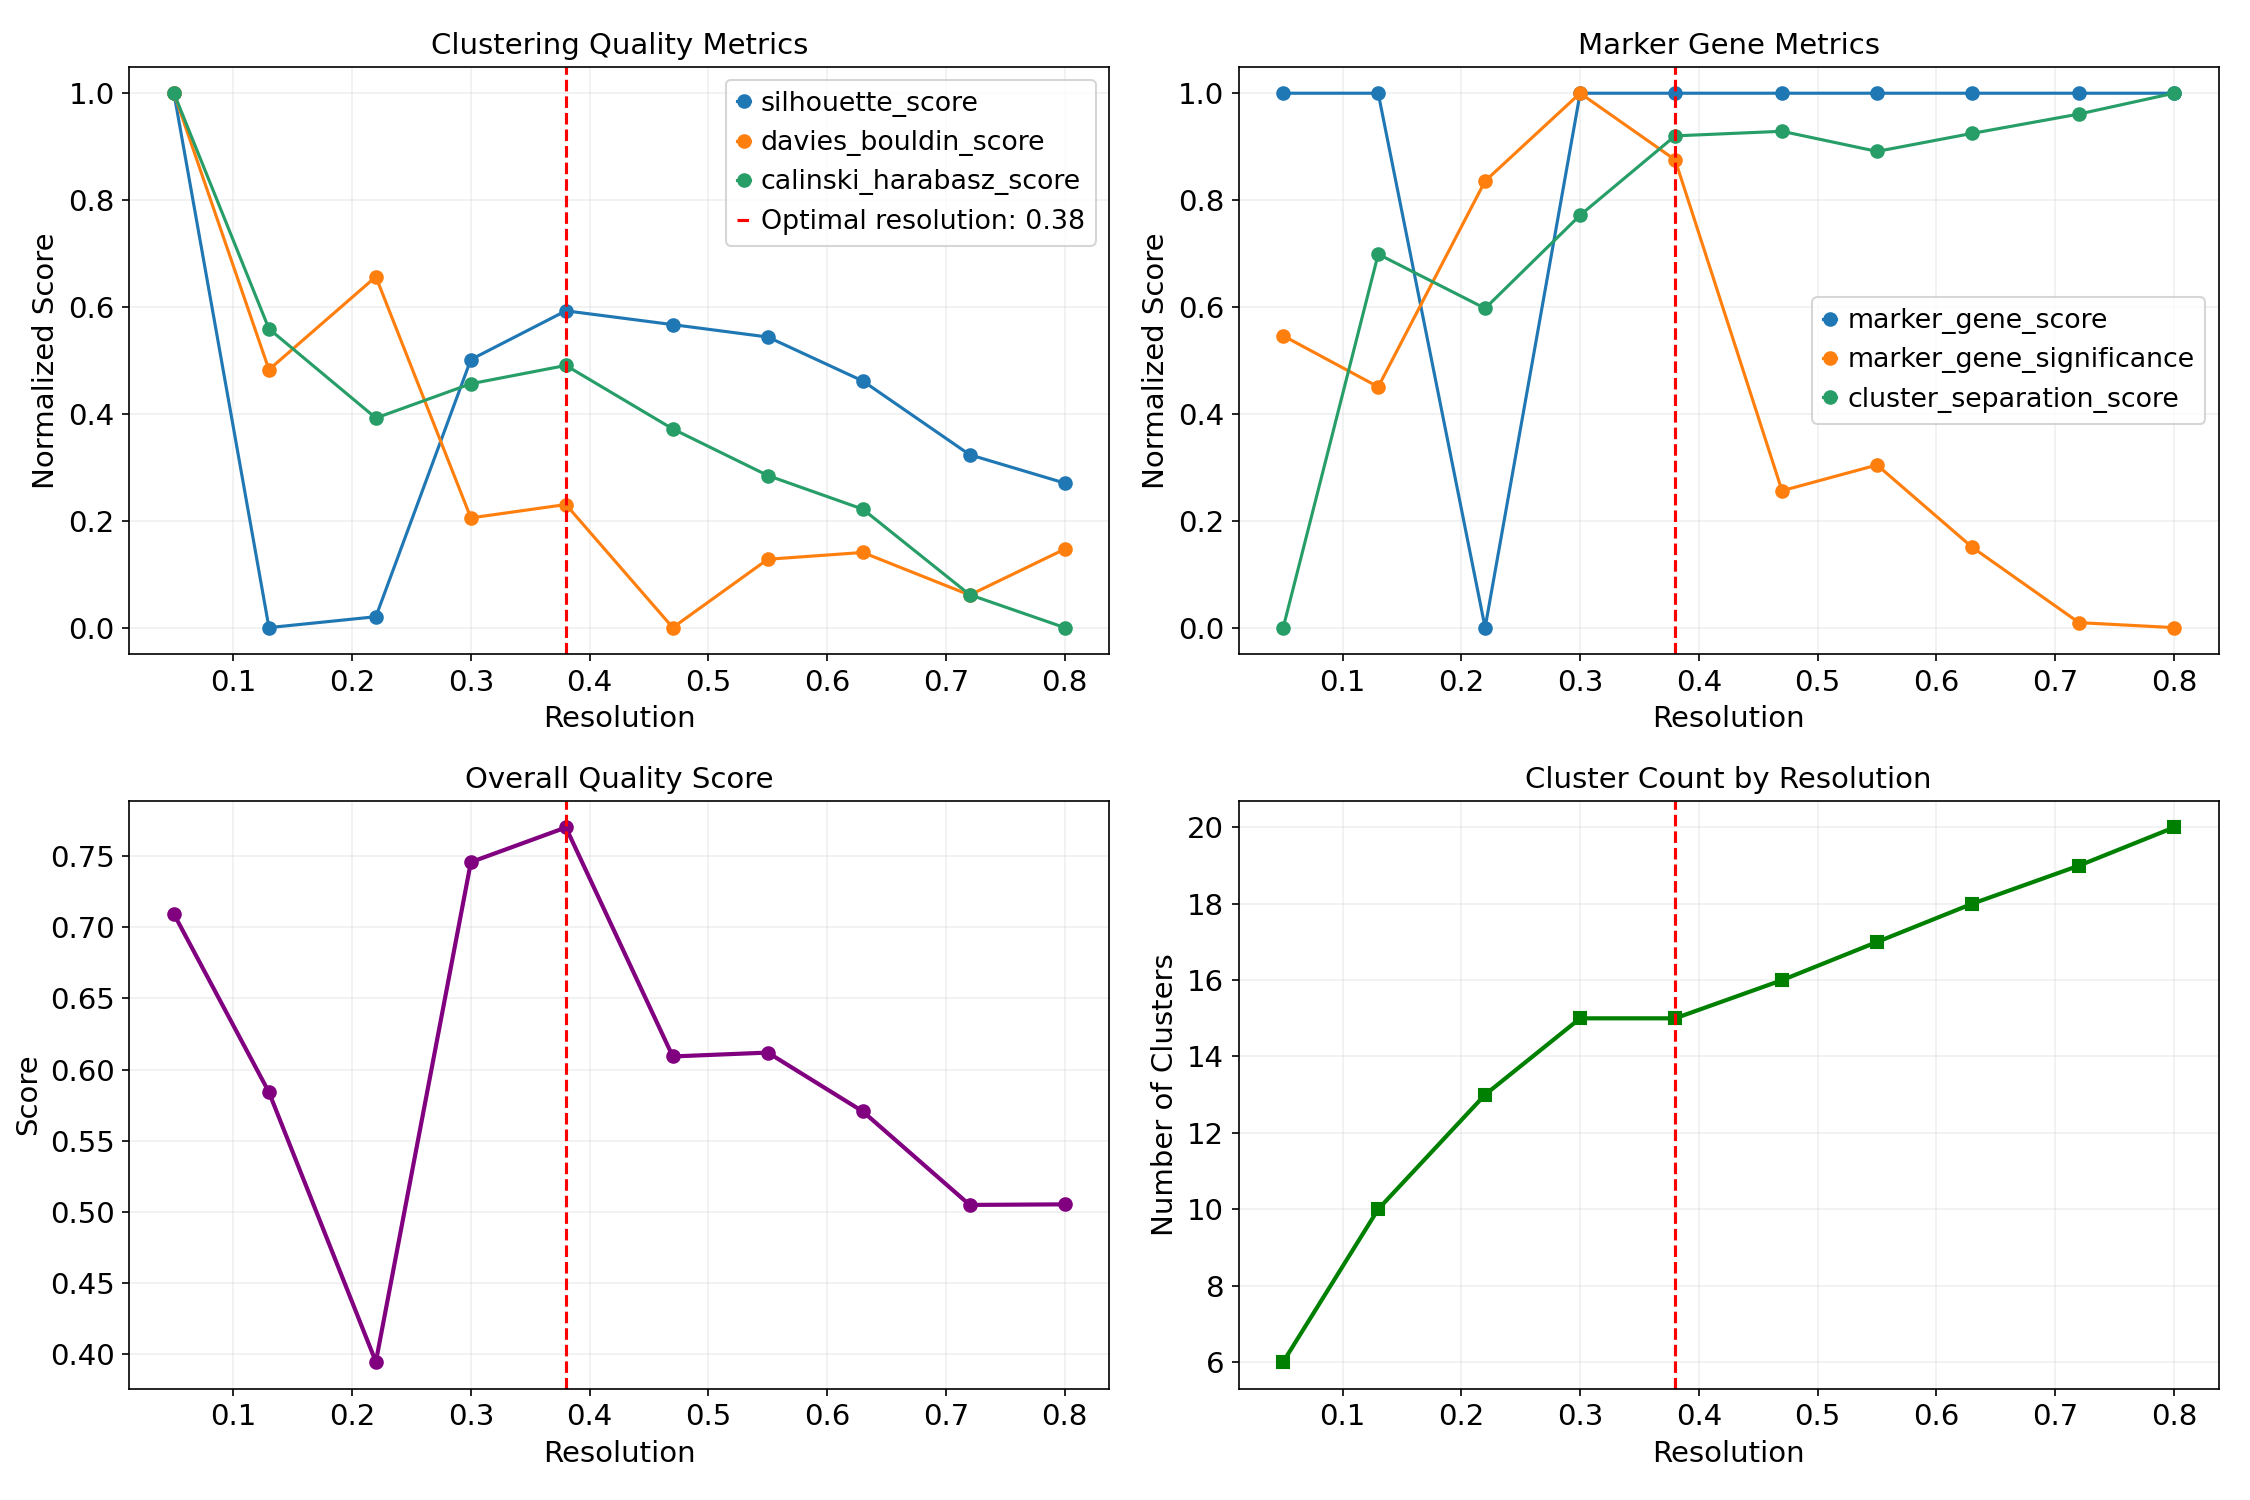

In [21]:
# Display the main clustering quality metrics visualization
from IPython.display import Image, display

print("Clustering quality metrics across resolutions:")
metrics_img = Image(os.path.join(OUTPUT_DIR, 'my_cluster_analysis', 'evaluation', 'clustering_quality_metrics.png'))
display(metrics_img)

Contribution of each metric to the overall score:


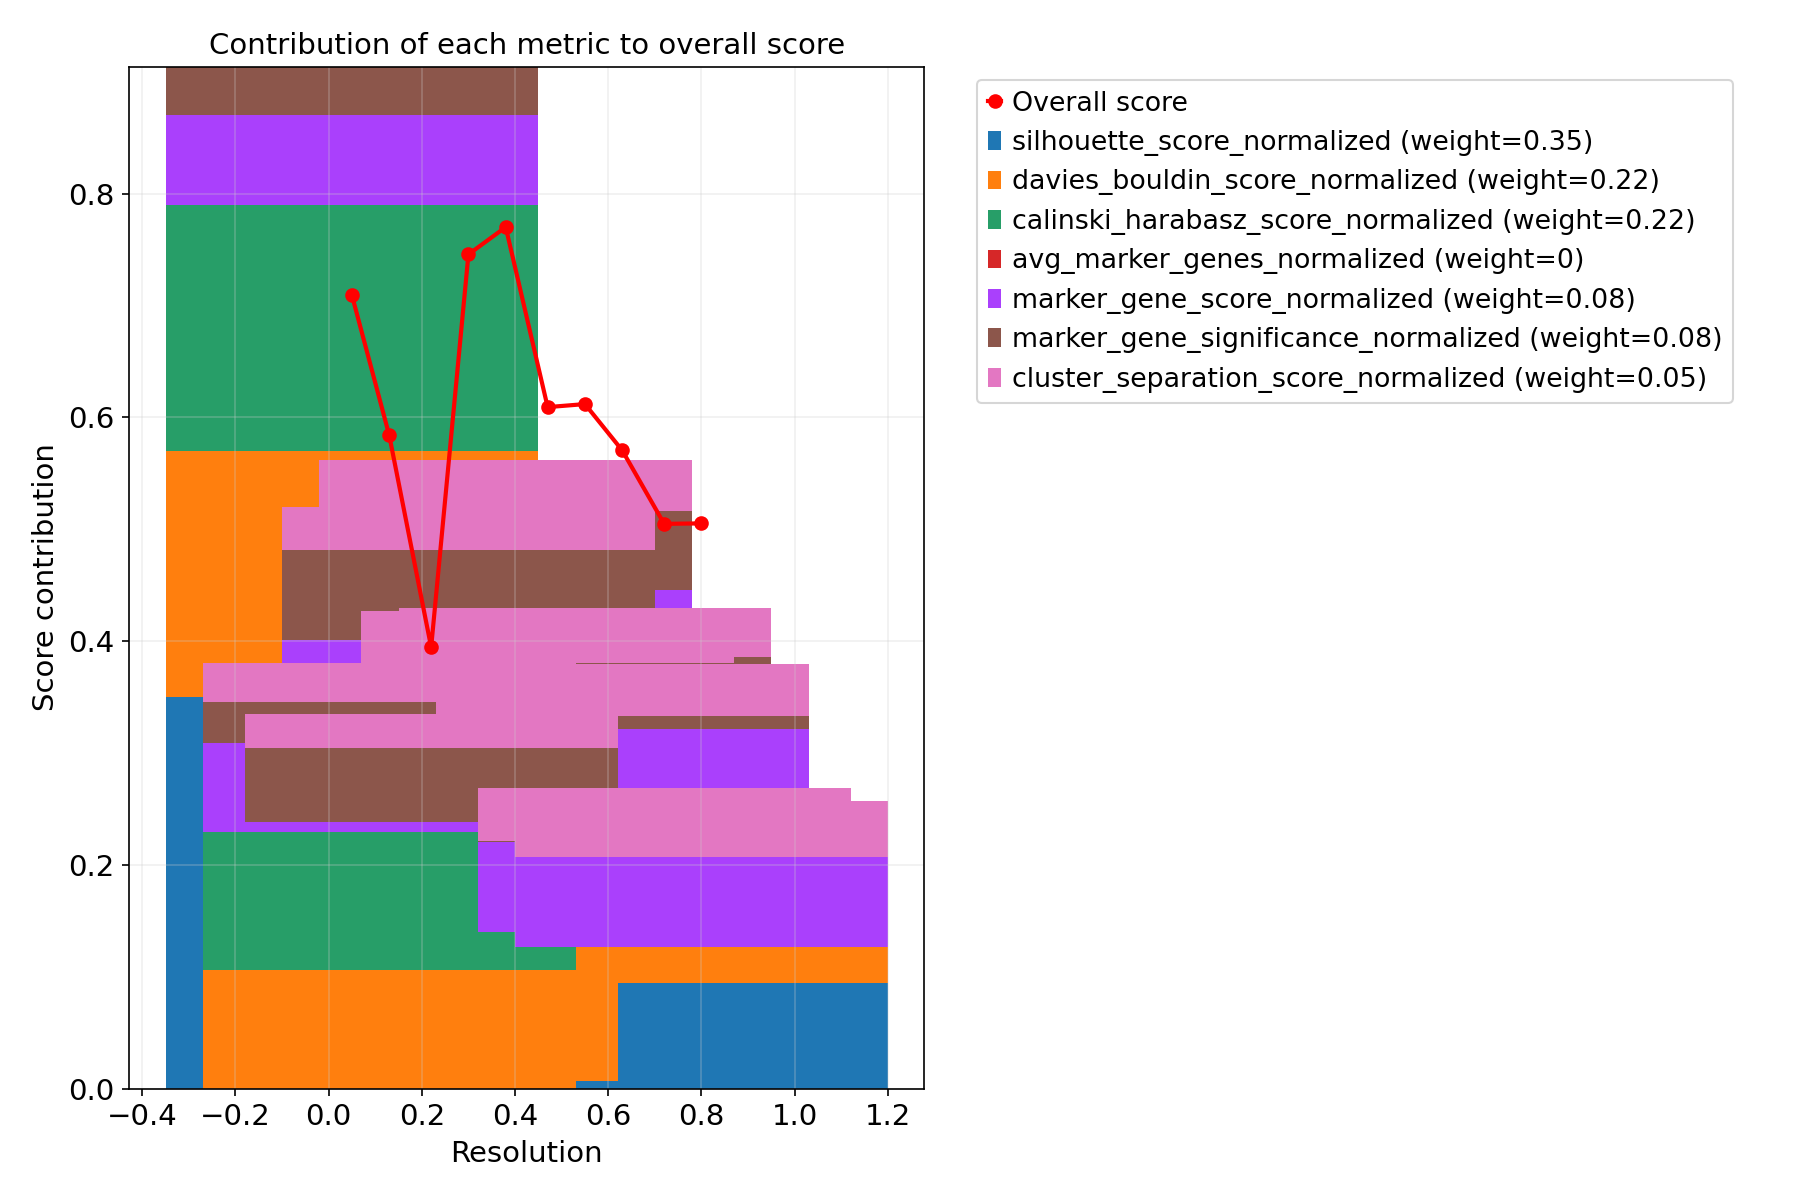

Individual metrics across resolutions:


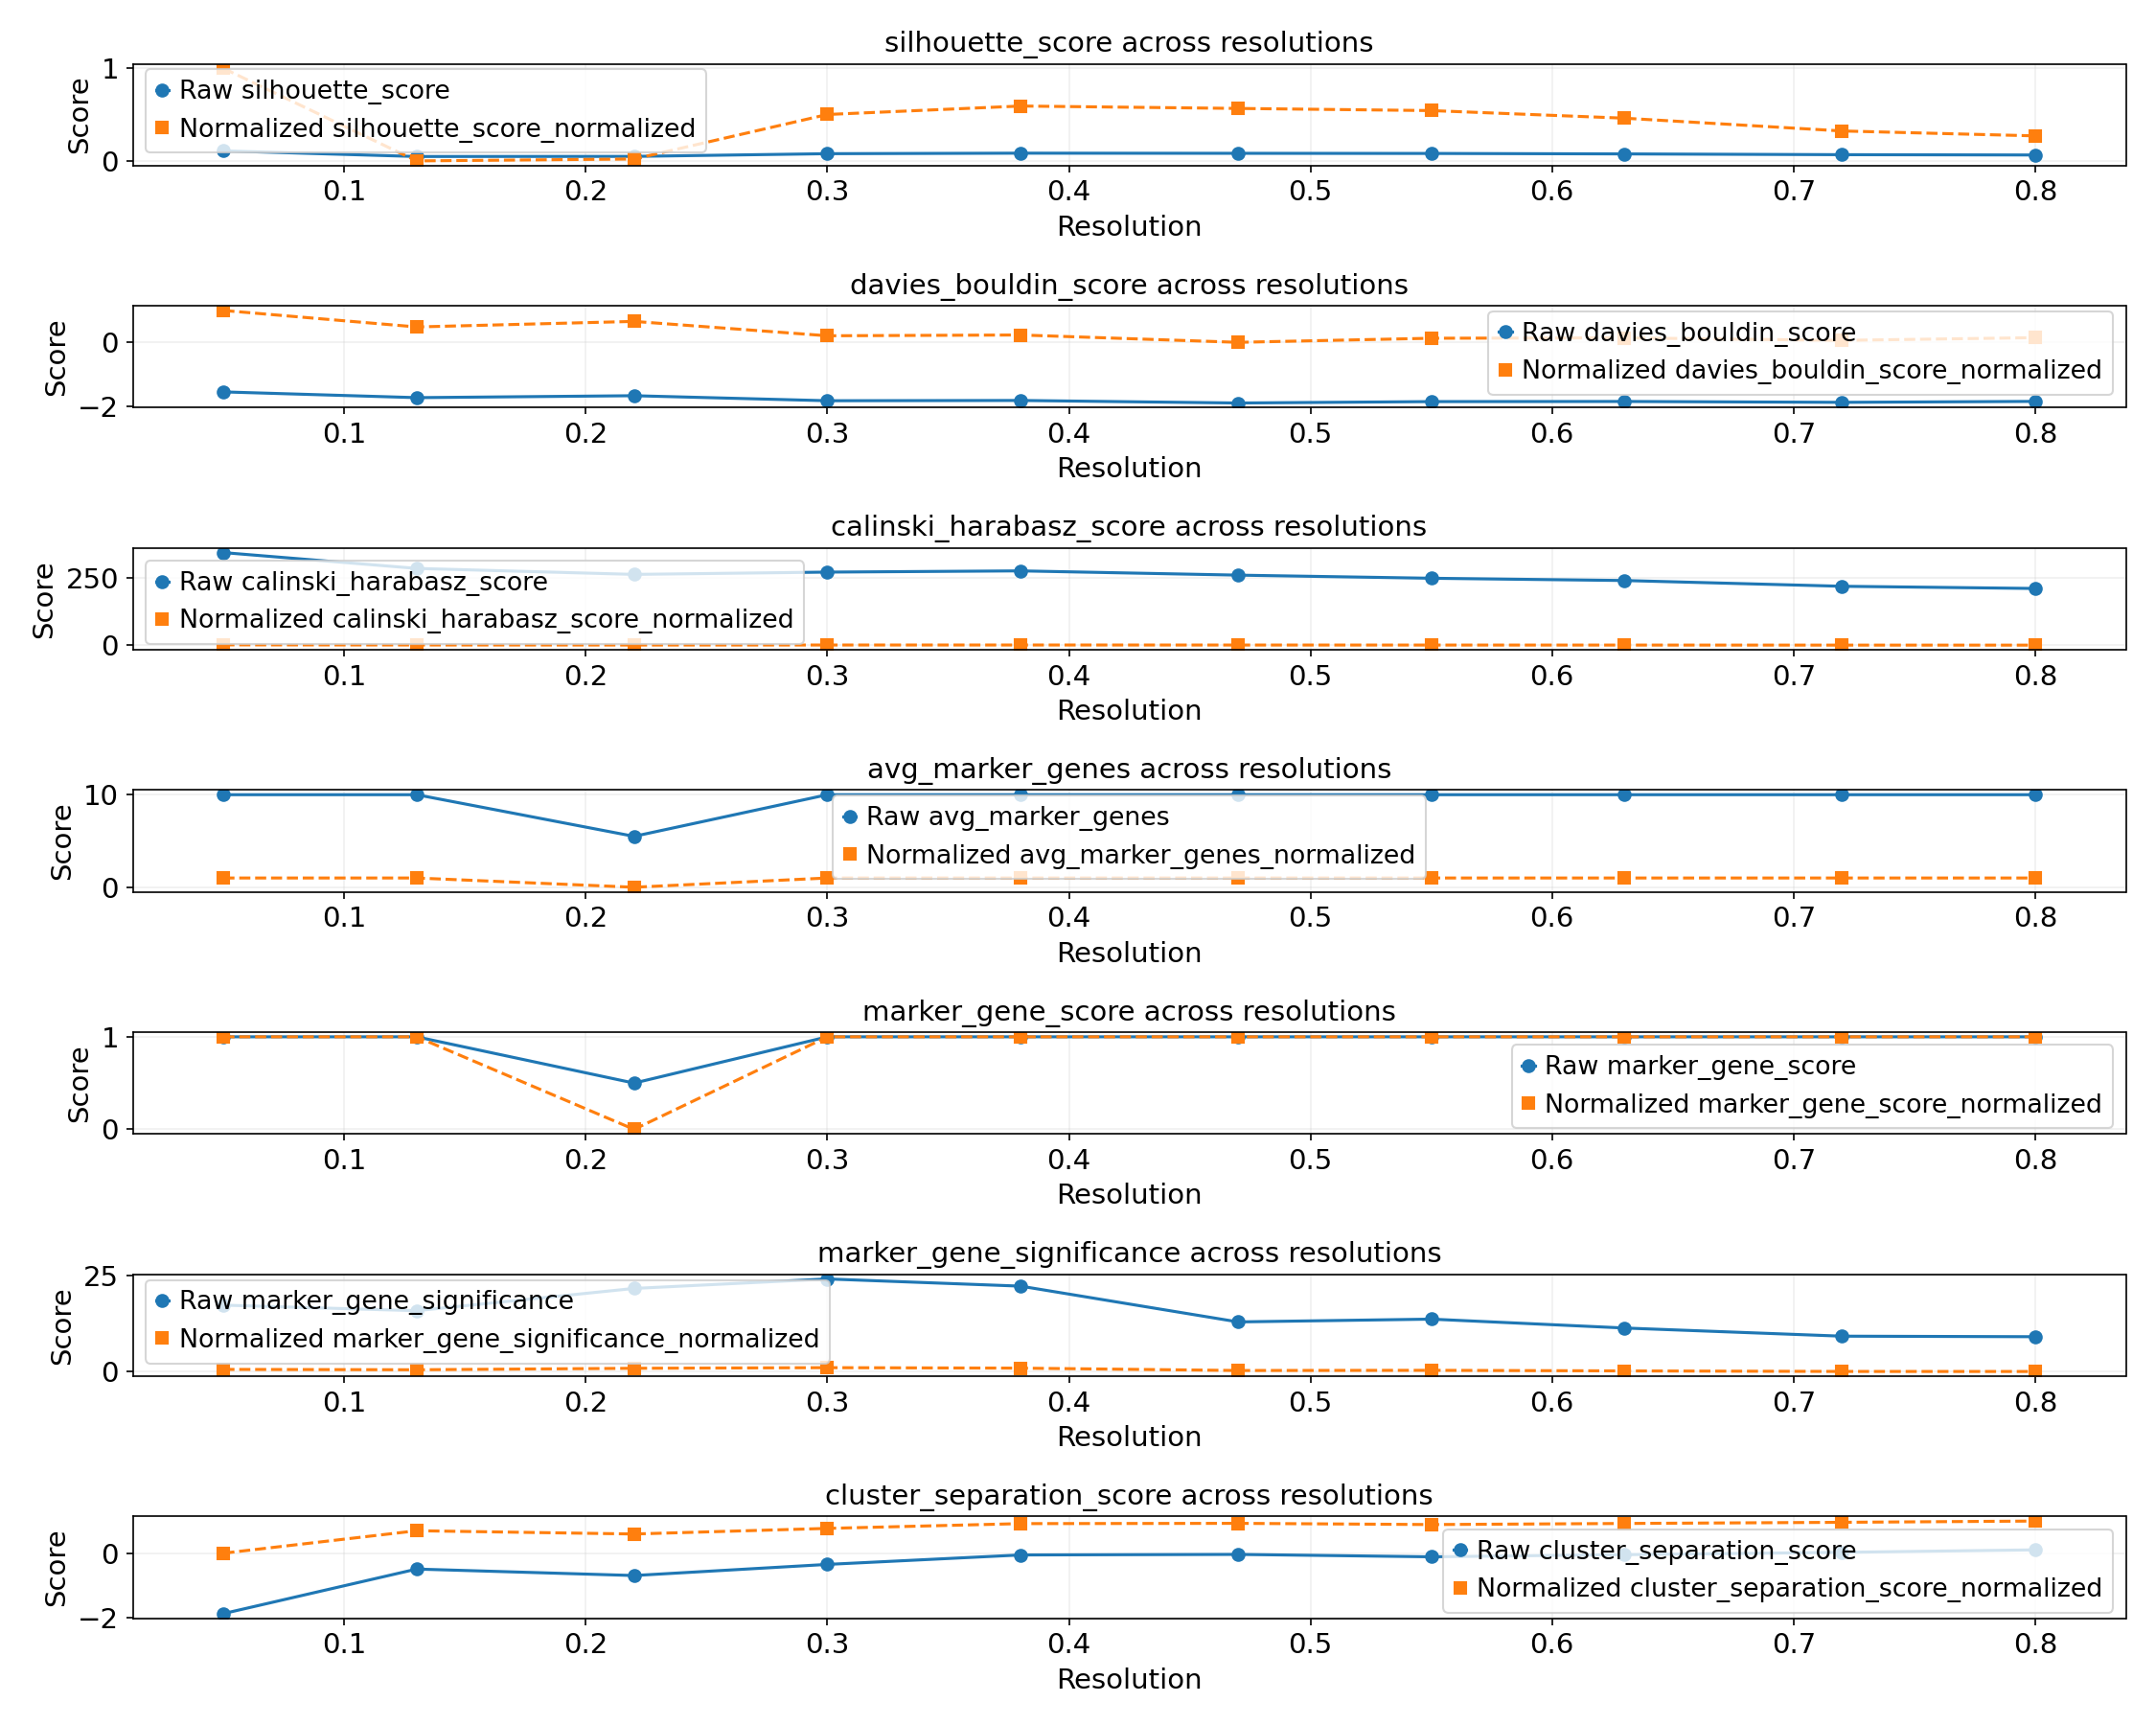

In [22]:
# Display metric contributions visualization if available
metric_details_path = os.path.join(OUTPUT_DIR, 'my_cluster_analysis', 'evaluation', 'metric_details')
if os.path.exists(metric_details_path):
    contributions_img = Image(os.path.join(metric_details_path, 'metric_contributions.png'))
    print("Contribution of each metric to the overall score:")
    display(contributions_img)
    
    individual_metrics_img = Image(os.path.join(metric_details_path, 'individual_metrics.png'))
    print("Individual metrics across resolutions:")
    display(individual_metrics_img)

In [23]:
# Load and display the metric contribution summary
contribution_summary_path = os.path.join(OUTPUT_DIR, 'my_cluster_analysis', 'evaluation', 'metric_details', 'metric_contribution_summary.csv')
if os.path.exists(contribution_summary_path):
    contribution_df = pd.read_csv(contribution_summary_path)
    print("Metric contribution summary:")
    display(contribution_df)

# %% [markdown]
# ## 8.2 Marker Genes for Optimal Clustering

Metric contribution summary:


,resolution,n_clusters,overall_score,silhouette_score_normalized_contribution,davies_bouldin_score_normalized_contribution,calinski_harabasz_score_normalized_contribution,avg_marker_genes_normalized_contribution,marker_gene_score_normalized_contribution,marker_gene_significance_normalized_contribution,cluster_separation_score_normalized_contribution
0,0.05,6,0.709221,0.350000,0.220000,0.220000,0.0,0.08,0.043688,0.000000
1,0.13,10,0.584037,0.000000,0.106189,0.122997,0.0,0.08,0.036038,0.034942
2,0.22,13,0.394552,0.007138,0.144466,0.086278,0.0,0.00,0.066853,0.029869
3,0.30,15,0.745750,0.175566,0.045165,0.100397,0.0,0.08,0.080000,0.038586
4,0.38,15,0.770112,0.207486,0.050670,0.107924,0.0,0.08,0.070025,0.046010
5,0.47,16,0.609196,0.198432,0.000000,0.081795,0.0,0.08,0.020488,0.046438
6,0.55,17,0.611906,0.190321,0.028140,0.062613,0.0,0.08,0.024347,0.044555
7,0.63,18,0.570531,0.161531,0.030937,0.048760,0.0,0.08,0.012045,0.046241
8,0.72,19,0.504843,0.113222,0.013414,0.013541,0.0,0.08,0.000746,0.048050
9,0.80,20,0.505256,0.094667,0.032306,0.000000,0.0,0.08,0.000000,0.050000


In [24]:
# Only show the marker genes information, without the heatmap
leiden_key = f'leiden_{optimal_resolution}'

# Check if we have marker genes information and display them
if f"rank_genes_{optimal_resolution}" in adata.uns:
    # Get top markers for each cluster (adjust n_genes as needed)
    n_top_genes = 20
    
    # Load and display top markers for each cluster in the optimal clustering
    markers_file = os.path.join(OUTPUT_DIR, 'my_cluster_analysis', 'marker_analysis', f'cluster_markers_res{optimal_resolution}.csv')
    if os.path.exists(markers_file):
        markers_df = pd.read_csv(markers_file)
        
        # Create a more readable format for marker genes by cluster
        top_markers_by_cluster = {}
        for cluster in sorted(markers_df['cluster'].unique()):
            cluster_markers = markers_df[markers_df['cluster'] == cluster].sort_values('pvals_adj').head(10)
            top_markers_by_cluster[cluster] = list(zip(
                cluster_markers['names'], 
                cluster_markers['logfoldchanges'].round(2),
                cluster_markers['pvals_adj'].apply(lambda x: f"{x:.2e}")
            ))
        
        # Display top markers for each cluster
        print(f"Top marker genes for each cluster at resolution {optimal_resolution}:")
        for cluster, markers in top_markers_by_cluster.items():
            print(f"\nCluster {cluster}:")
            for i, (gene, lfc, pval) in enumerate(markers, 1):
                print(f"  {i}. {gene} (log2FC: {lfc}, adj.p-val: {pval})")
else:
    print("No marker gene information available for the optimal clustering.")

Top marker genes for each cluster at resolution 0.38:

Cluster 0:
  1. A930018P22Rik (log2FC: -8.28, adj.p-val: 9.89e-01)
  2. Npw (log2FC: -3.8, adj.p-val: 9.89e-01)
  3. Gm57164 (log2FC: -5.28, adj.p-val: 9.89e-01)
  4. Anxa8 (log2FC: -3.25, adj.p-val: 9.89e-01)
  5. Hp (log2FC: -4.09, adj.p-val: 9.89e-01)
  6. Osm (log2FC: -2.19, adj.p-val: 9.89e-01)
  7. Golt1a (log2FC: -2.9, adj.p-val: 9.89e-01)
  8. Gm57350 (log2FC: -2.5, adj.p-val: 9.89e-01)
  9. Krt18 (log2FC: -2.99, adj.p-val: 9.89e-01)
  10. H2-Ab1 (log2FC: -3.85, adj.p-val: 9.89e-01)

Cluster 1:
  1. Hpgds (log2FC: 4.17, adj.p-val: 1.40e-01)
  2. Gmppa (log2FC: -1.73, adj.p-val: 2.80e-01)
  3. Fam234a (log2FC: -2.65, adj.p-val: 2.89e-01)
  4. Mfsd1 (log2FC: 1.99, adj.p-val: 3.00e-01)
  5. Anxa5 (log2FC: 2.28, adj.p-val: 3.02e-01)
  6. Aspscr1 (log2FC: -0.25, adj.p-val: 3.62e-01)
  7. Ptprb (log2FC: -0.65, adj.p-val: 3.75e-01)
  8. Brpf1 (log2FC: 1.03, adj.p-val: 4.00e-01)
  9. Tsc2 (log2FC: 5.59, adj.p-val: 4.04e-01)
  10. T

In [25]:
print("NOTE: Heatmap generation has been moved to a separate script.")
print("Please use the generate_marker_heatmaps.py script to create heatmaps from the saved .h5ad files.")

# %% [markdown]
# # 9. Summary and Conclusion

NOTE: Heatmap generation has been moved to a separate script.
Please use the generate_marker_heatmaps.py script to create heatmaps from the saved .h5ad files.


In [26]:
# Load and display the analysis summary
summary_path = os.path.join(OUTPUT_DIR, 'my_cluster_analysis', 'analysis_summary.txt')
if os.path.exists(summary_path):
    with open(summary_path, 'r') as f:
        summary_text = f.read()
    
    from IPython.display import Markdown
    display(Markdown(f"```\n{summary_text}\n```"))

```
==================================================
CLUSTERING ANALYSIS SUMMARY
==================================================

Date: 2025-03-28 09:59:04
Analysis duration: 279.3 seconds

Resolutions tested: 10
Resolution range: 0.05 to 0.8

OPTIMAL CLUSTERING RESULT:
- Optimal resolution: 0.38
- Number of clusters: 15
- Silhouette score: 0.0835
- Davies-Bouldin score: 1.8254 (lower is better)
- Calinski-Harabasz score: 274.2
- Avg. marker genes per cluster: 10.0
- Marker gene score: 1.0000
- Overall quality score: 0.7701

Results saved to:
- /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Linda_RNA/post_analysis/individual_data_analysis_opt_clusters/cellranger_counts_R26_Emx1_Ctrl_adult_0/my_cluster_analysis

All clustering resolutions saved in the AnnData object:
- leiden_0.05: 6 clusters
- leiden_0.13: 10 clusters
- leiden_0.22: 13 clusters
- leiden_0.3: 15 clusters
- leiden_0.38: 15 clusters
- leiden_0.47: 16 clusters
- leiden_0.55: 17 clusters
- leiden_0.63: 18 clusters
- leiden_0.72: 19 clusters
- leiden_0.8: 20 clusters

```

In [27]:
# Print final summary
print(f"\n{'='*50}")
print(f"CLUSTERING ANALYSIS COMPLETED")
print(f"{'='*50}")
print(f"Sample: {SAMPLE_NAME}")
print(f"Optimal resolution: {optimal_resolution}")
print(f"Number of clusters: {len(adata.obs[f'leiden_{optimal_resolution}'].unique())}")
print(f"Total cells analyzed: {adata.n_obs}")
print(f"Results saved to: {os.path.abspath(OUTPUT_DIR)}")
print(f"{'='*50}")





CLUSTERING ANALYSIS COMPLETED
Sample: Emx1_Ctrl
Optimal resolution: 0.38
Number of clusters: 15
Total cells analyzed: 4707
Results saved to: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Linda_RNA/post_analysis/individual_data_analysis_opt_clusters/cellranger_counts_R26_Emx1_Ctrl_adult_0
